Please upload your Cleveland Heart CSV file (no header expected).


Saving data.csv to data (1).csv
Loaded file: data (1).csv
Shape: (303, 14)
     0    1    2      3      4    5    6      7    8    9    10   11   12  13
0  63.0  1.0  1.0  145.0  233.0  1.0  2.0  150.0  0.0  2.3  3.0  0.0  6.0   0
1  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0  1.5  2.0  3.0  3.0   1
2  67.0  1.0  4.0  120.0  229.0  0.0  2.0  129.0  1.0  2.6  2.0  2.0  7.0   1
3  37.0  1.0  3.0  130.0  250.0  0.0  0.0  187.0  0.0  3.5  3.0  0.0  3.0   0
4  41.0  0.0  2.0  130.0  204.0  0.0  2.0  172.0  0.0  1.4  1.0  0.0  3.0   0
Training L1-regularized model...
Epoch 0 | Loss (l1): 0.693152
Epoch 500 | Loss (l1): 0.366205
Epoch 1000 | Loss (l1): 0.347277
Epoch 1500 | Loss (l1): 0.341695
Epoch 2000 | Loss (l1): 0.339195
Epoch 2500 | Loss (l1): 0.337850

Training L2-regularized model...
Epoch 0 | Loss (l2): 0.693147
Epoch 500 | Loss (l2): 0.365487
Epoch 1000 | Loss (l2): 0.346543
Epoch 1500 | Loss (l2): 0.340932
Epoch 2000 | Loss (l2): 0.338427
Epoch 2500 | Loss (l2): 0.337089

C

/tmp/ipython-input-3824533370.py:176: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr[order], fpr[order])


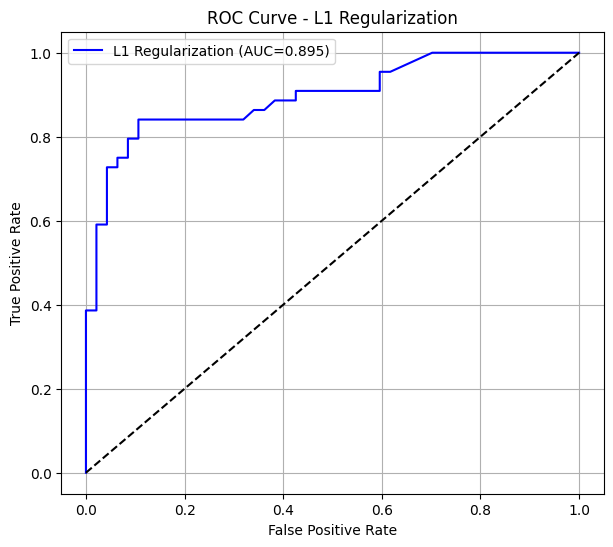

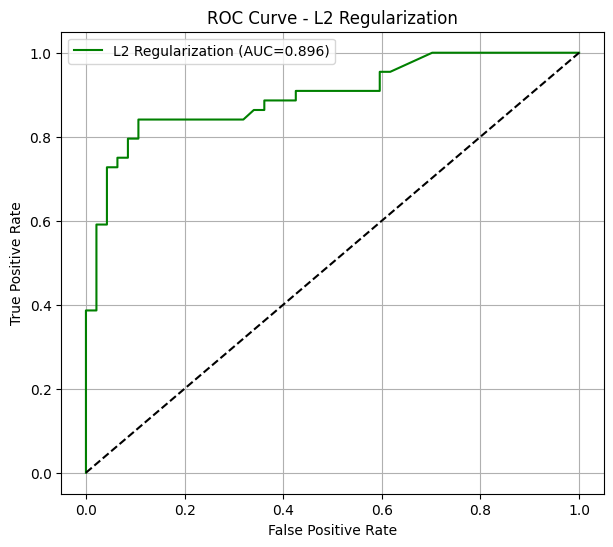

In [2]:
# Colab-ready NumPy logistic regression (L1 & L2) with ROC & confusion matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# --------------------------------------------------------
# Step 1: Upload dataset (Colab)
# --------------------------------------------------------
print("Please upload your Cleveland Heart CSV file (no header expected).")
uploaded = files.upload()  # interactive upload
if not uploaded:
    raise SystemExit("No file uploaded. Re-run the cell and upload the file.")

fname = next(iter(uploaded.keys()))
df = pd.read_csv(fname, header=None)  # keep header=None to match your file format
print("Loaded file:", fname)
print("Shape:", df.shape)
print(df.head())

# optional check: expecting 14 columns
if df.shape[1] != 14:
    raise ValueError(f"Expected 14 columns but found {df.shape[1]}. Please check file format.")

# --------------------------------------------------------
# Step 1b: Set column names (same as before)
# --------------------------------------------------------
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak",
    "slope", "ca", "thal", "num"
]
df.columns = columns

# --------------------------------------------------------
# Step 1c: Prepare X, y
# --------------------------------------------------------
X = df.drop("num", axis=1).values.astype(float)
y = df["num"].values
y = (y > 0).astype(int)  # binary target (0 or 1)

# --------------------------------------------------------
# Step 2: Train-test split (70-30)
# --------------------------------------------------------
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
split = int(0.7 * len(X))
train_idx, test_idx = indices[:split], indices[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --------------------------------------------------------
# Step 3: Feature normalization (important for logistic regression)
# --------------------------------------------------------
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
# avoid division by zero for constant columns
std_adj = std.copy()
std_adj[std_adj == 0] = 1.0

X_train = (X_train - mean) / std_adj
X_test = (X_test - mean) / std_adj

# Add bias column
X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# --------------------------------------------------------
# Step 4: Define helper functions
# --------------------------------------------------------
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_pred, weights, reg_type=None, lambda_=0.1):
    m = len(y)
    eps = 1e-9
    loss = (-1/m) * np.sum(y * np.log(y_pred + eps) + (1 - y) * np.log(1 - y_pred + eps))

    if reg_type == "l2":
        loss += (lambda_ / (2*m)) * np.sum(weights[1:] ** 2)
    elif reg_type == "l1":
        loss += (lambda_ / (2*m)) * np.sum(np.abs(weights[1:]))
    return loss

def gradient_descent(X, y, reg_type=None, lambda_=0.1, lr=0.01, epochs=2000, verbose_every=500):
    m, n = X.shape
    weights = np.zeros(n)
    for epoch in range(epochs):
        z = X @ weights
        y_pred = sigmoid(z)
        grad = (1/m) * (X.T @ (y_pred - y))

        if reg_type == "l2":
            grad[1:] += (lambda_ / m) * weights[1:]
        elif reg_type == "l1":
            # subgradient for L1 (sign); note this is approximate but common
            grad[1:] += (lambda_ / m) * np.sign(weights[1:])

        weights -= lr * grad

        if verbose_every and epoch % verbose_every == 0:
            loss = compute_loss(y, y_pred, weights, reg_type, lambda_)
            print(f"Epoch {epoch} | Loss ({reg_type}): {loss:.6f}")
    return weights

# --------------------------------------------------------
# Step 5: Train models with L1 and L2 regularization
# --------------------------------------------------------
print("Training L1-regularized model...")
w_l1 = gradient_descent(X_train, y_train, reg_type="l1", lambda_=0.1, lr=0.01, epochs=3000, verbose_every=500)

print("\nTraining L2-regularized model...")
w_l2 = gradient_descent(X_train, y_train, reg_type="l2", lambda_=0.1, lr=0.01, epochs=3000, verbose_every=500)

# --------------------------------------------------------
# Step 6: Predictions
# --------------------------------------------------------
def predict(X, weights, threshold=0.5):
    return (sigmoid(X @ weights) >= threshold).astype(int)

y_pred_l1 = predict(X_test, w_l1)
y_pred_l2 = predict(X_test, w_l2)

# --------------------------------------------------------
# Step 7: Confusion Matrix & basic metrics
# --------------------------------------------------------
def confusion_matrix_np(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TP, FP], [FN, TN]])

def compute_metrics_from_cm(cm):
    TP, FP = cm[0,0], cm[0,1]
    FN, TN = cm[1,0], cm[1,1]
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    return accuracy, precision, recall, f1

cm_l1 = confusion_matrix_np(y_test, y_pred_l1)
cm_l2 = confusion_matrix_np(y_test, y_pred_l2)

print("\nConfusion Matrix (L1):\n", cm_l1)
acc, prec, rec, f1 = compute_metrics_from_cm(cm_l1)
print(f"L1 -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

print("\nConfusion Matrix (L2):\n", cm_l2)
acc, prec, rec, f1 = compute_metrics_from_cm(cm_l2)
print(f"L2 -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

# --------------------------------------------------------
# Step 8: ROC Curve (manual, separate plots for L1 and L2)
# --------------------------------------------------------
def roc_curve_data(y_true, y_scores, n_thresholds=200):
    thresholds = np.linspace(0, 1, n_thresholds)
    tprs, fprs = [], []
    for t in thresholds:
        y_pred = (y_scores >= t).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        FN = np.sum((y_true == 1) & (y_pred == 0))
        TN = np.sum((y_true == 0) & (y_pred == 0))
        tpr = TP / (TP + FN + 1e-9)
        fpr = FP / (FP + TN + 1e-9)
        tprs.append(tpr)
        fprs.append(fpr)
    return np.array(fprs), np.array(tprs)

def auc_score(fpr, tpr):
    order = np.argsort(fpr)
    return np.trapz(tpr[order], fpr[order])

# Probabilities for both models
y_prob_l1 = sigmoid(X_test @ w_l1)
y_prob_l2 = sigmoid(X_test @ w_l2)

# ROC curve data
fpr_l1, tpr_l1 = roc_curve_data(y_test, y_prob_l1)
fpr_l2, tpr_l2 = roc_curve_data(y_test, y_prob_l2)

# AUCs
auc_l1 = auc_score(fpr_l1, tpr_l1)
auc_l2 = auc_score(fpr_l2, tpr_l2)

# ---- Plot 1: L1 ROC Curve ----
plt.figure(figsize=(7,6))
plt.plot(fpr_l1, tpr_l1, color='blue', label=f"L1 Regularization (AUC={auc_l1:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - L1 Regularization")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot 2: L2 ROC Curve ----
plt.figure(figsize=(7,6))
plt.plot(fpr_l2, tpr_l2, color='green', label=f"L2 Regularization (AUC={auc_l2:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - L2 Regularization")
plt.legend()
plt.grid(True)
plt.show()
